In [1]:
pwd

'/data2/mito_lineage/Analysis/peaks_expression/CHIP_april08_2021'

In [2]:
config_f = "config.yaml"
outdir=""

In [ ]:
if outdir == "":
    outdir="./output"

if not os.path.exists(outdir):
    os.mkdir(outdir)

In [3]:
from src.utils.parse_config import read_config_file
from os.path import join, dirname
import pandas as pd
from glob import glob
config = read_config_file(config_f)
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
config

{'global': 'PROJECT',
 'indir': '/data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist',
 'experiment': 'CHIP_april08_2021',
 'genome': 'MTblacklist',
 'samples': ['Control', 'Flt3l', 'Input']}

### Load:
1. Raw cells barcode w qc info
2. filtered cells barcode list
3. Peak-by-cell sparse matrix
4. Peak gene annotations 
5. Graph clustering filtered cells cluster label
6. TF-by-cell sparse count matrix
7. TF labels

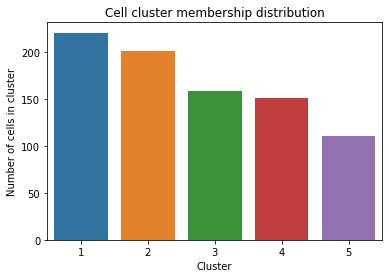

In [4]:
curr_in = join(config["indir"], config['samples'][0], 'outs')

### Create 1-based cell barcode index 

cells = pd.read_csv(join(curr_in,"singlecell.csv"))
cells

good_cells = cells[~(cells["cell_id"]=="None")].copy()
good_cells["ID"] = np.arange(1,len(good_cells)+1)
good_cells

cell_inds = pd.read_csv(join(curr_in, "filtered_peak_bc_matrix","barcodes.tsv"),header=None)
cell_inds

## Load peak annotations

peak_annotations = pd.read_csv(join(config["indir"], config['samples'][0], 'outs','peak_annotation.tsv'),sep='\t')
peak_annotations


### Load clusters

cluster_f = glob(join(config["indir"], config['samples'][0], 'outs','analysis',"clustering", "graphclust","clusters.csv"))
clusters_df = pd.read_csv(cluster_f[0])
clusters_df

%matplotlib inline
sns.countplot(clusters_df["Cluster"])
plt.title("Cell cluster membership distribution")
plt.ylabel("Number of cells in cluster")
plt.xlabel("Cluster")
## Load peaks matrix

filename = join(config['indir'],config['samples'][0],'outs','filtered_peak_bc_matrix/matrix.mtx')
peaks_sparse_mtx = pd.read_csv(filename,sep=' ',skiprows=2, header=None).iloc[1:]
peaks_sparse_mtx.columns = ["Peak", "Cell", "Count"]

# Annotate peak count matrix with gene name

In [9]:
peaks_sparse_mtx["Cluster"] = peaks_sparse_mtx["Cell"].apply(lambda x: clusters_df.loc[x-1,"Cluster"])
peaks_sparse_mtx

,Peak,Cell,Count,Cluster
1,107868,1,2,2
2,107737,1,2,2
3,107289,1,2,2
4,107018,1,2,2
5,107001,1,2,2
...,...,...,...,...
6174919,84,843,2,3
6174920,76,843,2,3
6174921,40,843,2,3
6174922,30,843,2,3


In [10]:
peaks_sparse_mtx["gene"] = peaks_sparse_mtx["Peak"].apply(lambda x: peak_annotations.loc[x-1,"gene"])

## See the number of cells within a peak and number of peaks within a cell.

In [12]:
peaks_dense = peaks_sparse_mtx.pivot(index="Peak", columns="Cell",values="Count").fillna(0)
print((peaks_dense>0).sum())

Cell
1        195
2        380
3        972
4      14849
5        360
       ...  
839       79
840     4590
841      727
842    10922
843     7836
Length: 843, dtype: int64


Text(0.5, 1.0, 'Distribution of number of peaks seen in a cell across all cells')

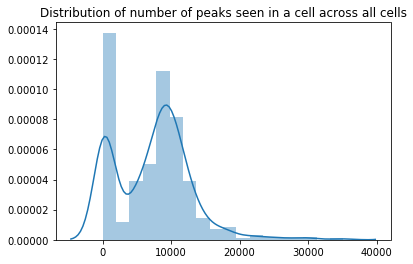

In [13]:
sns.distplot((peaks_dense>0).sum(axis=0))
plt.title("Distribution of number of peaks seen in a cell across all cells")

Text(0.5, 1.0, 'Distribution of the number of cells seen in a peak across all peaks')

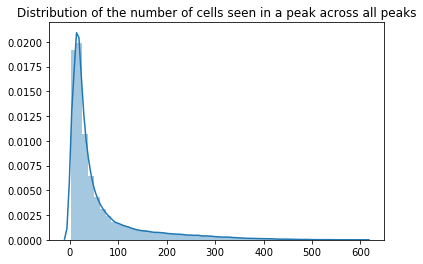

In [14]:
sns.distplot((peaks_dense>0).sum(axis=1))
plt.title("Distribution of the number of cells seen in a peak across all peaks")

## Look at CHIP mutations
- TP53
- U2AF1
- SF3B1
- SRSF2
- TET2
- IDH1
- IDH2  
TP53 and the splicing factor U2AF1 conferred the highest risk of AML development with hazard ratios of 12.5 and 7.9, respectively.16 This contrasts with hazard ratios for DNMT3A and TET2 of 1.4 and 1.6, respectively. In the study by Desai et al, mutations of TP53 and spliceosome genes (U2AF1, SF3B1,or SRSF2) also conferred a higher risk of AML development, with odds ratios of 47.2 and 7.4, respectively.17
They also identified IDH1, IDH2, and RUNX1 with PHF6 mutations as high-risk mutations. Re- markably, in this study, all persons with TP53 mutations (n 5 21) or IDH1/2 mutations (n 5 15) developed AML a median of 5 to 6 years from CH sampling.

In [15]:
chip_genes = ["TP53", "U2AF1", "SF3B1", "SRSF2", "TET2", "IDH1", "IDH2"]

In [16]:
chip_df = peak_annotations[peak_annotations["gene"].isin(chip_genes)]
chip_inds = peak_annotations[peak_annotations["gene"].isin(chip_genes)].index
chip_df["ID"] = chip_df.apply(lambda x: x["gene"]+"_"+x["peak_type"]+"_"+x["distance"],axis=1)
chip_df

/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,peak,gene,distance,peak_type,ID
17340,chr2_197378451_197378865,SF3B1,56162,distal,SF3B1_distal_56162
17341,chr2_197425773_197425880,SF3B1,9147,distal,SF3B1_distal_9147
17342,chr2_197434412_197435641,SF3B1,0,promoter,SF3B1_promoter_0
17343,chr2_197442560_197443246,SF3B1,-7470,distal,SF3B1_distal_-7470
17344,chr2_197443765_197444364,SF3B1,-8675,distal,SF3B1_distal_-8675
17738,chr2_208228484_208228798,IDH1,25524,distal,IDH1_distal_25524
17739,chr2_208250394_208250839,IDH1,3483,distal,IDH1_distal_3483
17740,chr2_208252804_208255891,IDH1,0,promoter,IDH1_promoter_0
28815,chr4_104963858_104963885,TET2,-181990,distal,TET2_distal_-181990
28816,chr4_104966560_104967136,TET2,-178739,distal,TET2_distal_-178739


(array([24.,  5.,  2.,  1.,  0.,  1.,  0.,  1.,  1.,  2.]),
 array([  1. ,  29.5,  58. ,  86.5, 115. , 143.5, 172. , 200.5, 229. ,
        257.5, 286. ]),
 <a list of 10 Patch objects>)

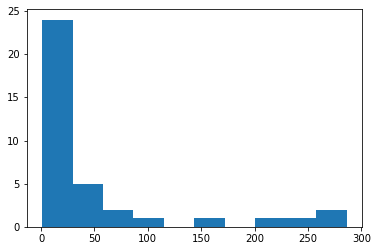

In [17]:
plt.hist((pd.merge(peaks_dense, chip_df[["ID"]], 
                  left_index=True, right_index=True).set_index("ID")>0).sum(axis=1))

In [18]:
chip_dist = (pd.merge(peaks_dense, chip_df[["ID"]], 
                  left_index=True, right_index=True).set_index("ID")>0).sum(axis=1)
chip_dist

ID
SF3B1_distal_56162      21
SF3B1_distal_9147       18
SF3B1_promoter_0         2
SF3B1_distal_-7470     282
SF3B1_distal_-8675      22
IDH1_distal_25524       71
IDH1_distal_3483        19
IDH1_promoter_0         14
TET2_distal_-181990    164
TET2_distal_-178739      1
TET2_distal_-171794     54
TET2_distal_-169121     18
TET2_distal_-161975     24
TET2_distal_-130857      2
TET2_distal_-122429     12
TET2_distal_-87256      27
TET2_distal_-86225      47
TET2_distal_-83756      12
TET2_distal_-31601     209
TET2_distal_-29165      48
TET2_distal_-26254       2
TET2_distal_-9570        1
TET2_distal_-4654       51
TET2_promoter_0          6
TET2_distal_2912       286
TET2_distal_8565        22
TET2_distal_11623        1
TET2_distal_23908       19
TET2_distal_44712        7
TET2_distal_49519       29
TET2_distal_142273      59
IDH2_distal_16907       11
IDH2_distal_2328        44
IDH2_distal_1553       102
IDH2_distal_-2007      243
IDH2_distal_-24388       4
IDH2_distal_-40041       

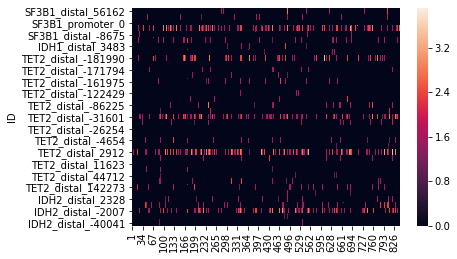

In [19]:
sns.heatmap(np.log2(1+pd.merge(peaks_dense, chip_df[["ID"]], 
                  left_index=True, right_index=True).set_index("ID")))

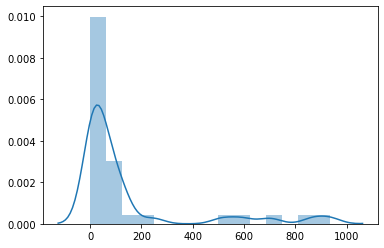

In [20]:
sns.distplot(pd.merge(peaks_dense, chip_df[["ID"]], left_index=True, right_index=True).set_index("ID").sum(axis=1))

## Look at how many T-cell annotated peaks (gene TRAC) were there and how many cells contained it

In [21]:
peak_annotations[peak_annotations["gene"] == "TRAC"]


,peak,gene,distance,peak_type
76357,chr14_22549904_22550609,TRAC,2399,distal
76358,chr14_22555557_22557677,TRAC,8052,distal
76359,chr14_22560824_22562335,TRAC,13319,distal


In [22]:
trac_peaks = peaks_sparse_mtx[peaks_sparse_mtx["gene"] == "TRAC"].groupby(["Peak", "Cell"]).size().reset_index().rename({0:"Count"},axis=1)

In [23]:
print("Number of cells for each peaks")
trac_peaks.groupby("Peak").size()

Number of cells for each peaks


Peak
76358     63
76359    346
76360    131
dtype: int64

In [24]:
print("Number of cells with at least one peak")
print(trac_peaks.groupby("Peak").size())
print("\n")
print("Number Cells with at least one peak annotated as TRAC:")
print((trac_peaks.pivot("Cell", columns="Peak").fillna(0)>0).any(axis=1).sum())

Number of cells with at least one peak
Peak
76358     63
76359    346
76360    131
dtype: int64


Number Cells with at least one peak annotated as TRAC:
415
